In [1]:
from ast import literal_eval
from pathlib import Path

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sec_certs.dataset import CCDataset


In [2]:
dset = CCDataset.from_web()

df = dset.to_pandas()


Downloading: CCDataset:   0%|          | 0.00/180M [00:00<?, ?B/s]

/Users/vladimirpenaz/PycharmProjects/SDA/python_technology_material_3_10/.venv/lib/python3.10/site-packages/sec_certs/dataset/cc.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.astype(


In [3]:
dset.to_json("./CC_dataset.json")
# new_dset = CCDataset.from_json("./CC_dataset.json")
# assert dset == new_dset


In [4]:
# for item in df.itertuples():
#     print(item)
#     break

print(dset)



CCDataset:dataset, 6356 certificates


Number of certificates with OpenSSL in library: {2024: 58, 2025: 33, 2023: 53, 2022: 43, 2021: 62, 2020: 51, 2019: 38, 2016: 49, 2012: 14, 2005: 6, 2004: 2, 2018: 35, 2014: 16, 2013: 11, 2010: 5, 2009: 9, 2008: 12, 2006: 11, 2002: 1, 2017: 54, 2015: 36, 2011: 13, 2007: 11}


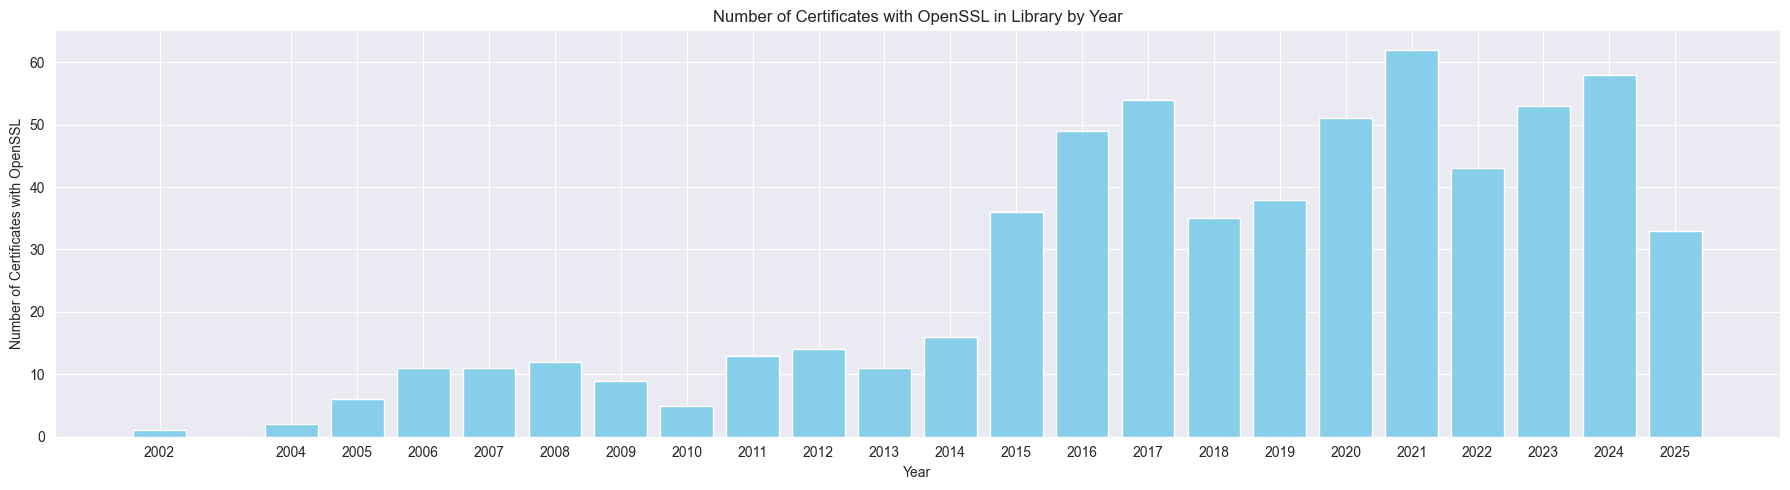

In [5]:
# cisco_certs = [cert for cert in dset if cert.pdf_data.report_keywords.crypto_library]

# print(f"Number of certificates with OpenSSL in library: {len(cisco_certs)}")

years_dict = {}

for cert in dset:
    if cert.pdf_data.report_keywords not in [None, []]:
        list_of_libs = cert.pdf_data.report_keywords["crypto_library"]
        if "OpenSSL" in list_of_libs:
            if years_dict.get(cert.not_valid_before.year):
                years_dict[cert.not_valid_before.year] += 1
            else:
                years_dict[cert.not_valid_before.year] = 1

print(f"Number of certificates with OpenSSL in library: {years_dict}")




# Sort the years for plotting
years = sorted(years_dict.keys())
counts = [years_dict[year] for year in years]

plt.figure(figsize=(18, 5))
plt.bar(years, counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Certificates with OpenSSL')
plt.title('Number of Certificates with OpenSSL in Library by Year')
plt.xticks(years)
plt.tight_layout()
plt.show()



In [6]:
# cisco_certs = [cert for cert in dset if cert.pdf_data.report_keywords.crypto_library]

# print(f"Number of certificates with OpenSSL in library: {len(cisco_certs)}")

counter = 0

for cert in dset:
    if cert.pdf_data.report_keywords not in [None, []]:
        list_of_libs = cert.pdf_data.report_keywords["crypto_library"]
        if "OpenSSL" in list_of_libs:
            counter += 1

print(f"Number of certificates with OpenSSL in library: {counter}")


Number of certificates with OpenSSL in library: 623


In [39]:
# Define column names
columns = ['Manufacturer', 'IssueDate', 'SunsetDate', 'OpenSSLMentioned', 'Country']

# Create the empty DataFrame
new_df = pd.DataFrame(columns=columns)


for cert in dset:
    if cert.pdf_data.report_keywords not in [None, []]:
        list_of_libs = cert.pdf_data.report_keywords["crypto_library"]
        if "OpenSSL" in list_of_libs:
            new_df.loc[len(new_df)] = [cert.manufacturer, cert.not_valid_before, cert.not_valid_after, cert.pdf_data.report_keywords["crypto_library"]["OpenSSL"]["OpenSSL"], cert.scheme]

print(new_df)

                                          Manufacturer   IssueDate  \
0                               CyberArk Software, Ltd  2024-07-03   
1                               CyberArk Software, Ltd  2024-07-03   
2                               CyberArk Software, Ltd  2024-07-03   
3                             Asseco Data Systems S.A.  2024-02-29   
4    Senetas Corporation Ltd, Distributed by Thales...  2025-03-25   
..                                                 ...         ...   
618                                Ricoh Company, Ltd.  2020-10-16   
619                                 Oracle Corporation  2023-04-12   
620                      Samsung Electronics Co., Ltd.  2015-08-21   
621                                Ricoh Company, Ltd.  2020-02-26   
622                                Ricoh Company, Ltd.  2020-02-13   

     SunsetDate  OpenSSLMentioned Country  
0    2029-07-03                 1      NL  
1    2029-07-03                 2      NL  
2    2029-07-03            

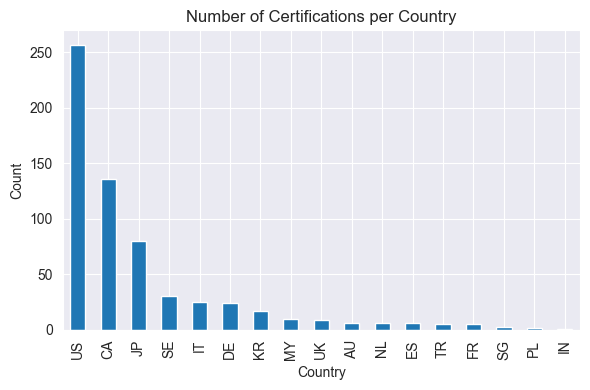

In [21]:
country_counts = new_df['Country'].value_counts()

country_counts.plot(kind='bar', figsize=(6, 4))
plt.title('Number of Certifications per Country')
plt.ylabel('Count')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

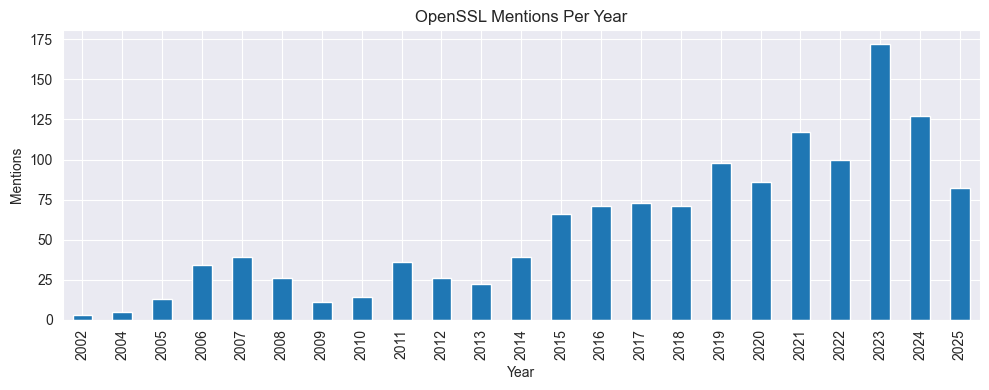

In [23]:

# Convert to datetime if not already
new_df['IssueDate'] = pd.to_datetime(new_df['IssueDate'])

# Extract year and group by it
new_df['Year'] = new_df['IssueDate'].dt.year
df_yearly = new_df.groupby('Year')['OpenSSLMentioned'].sum()

# Bar plot
df_yearly.plot(kind='bar', figsize=(10, 4))
plt.title('OpenSSL Mentions Per Year')
plt.ylabel('Mentions')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


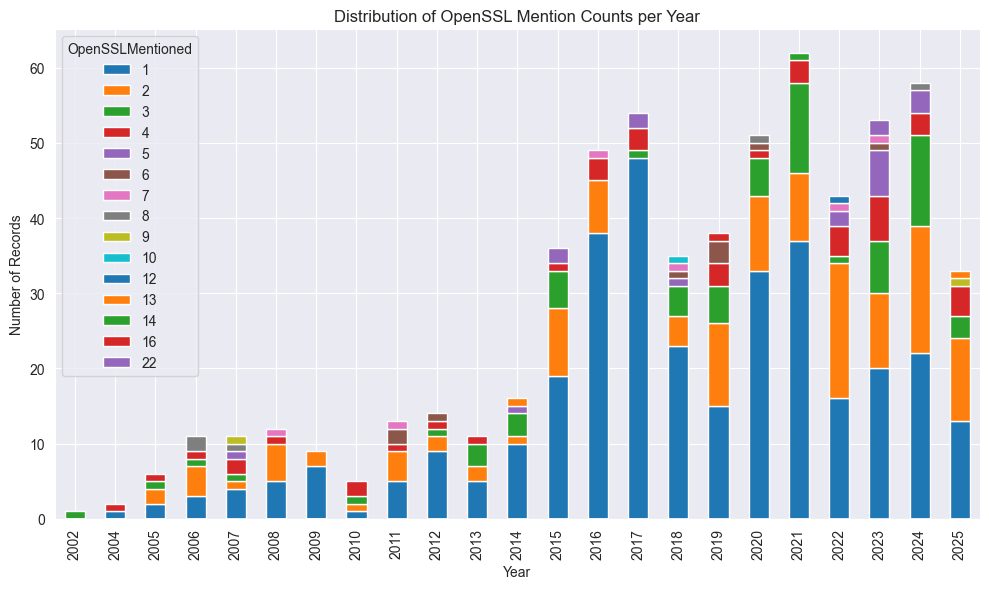

In [24]:
# Make sure date is in datetime format

# Extract year
new_df['Year'] = new_df['IssueDate'].dt.year

# Group by Year and OpenSSL_mentioned, then count how often each value occurs
mention_counts = new_df.groupby(['Year', 'OpenSSLMentioned']).size().unstack(fill_value=0)

# Plot
mention_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of OpenSSL Mention Counts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.legend(title='OpenSSLMentioned')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

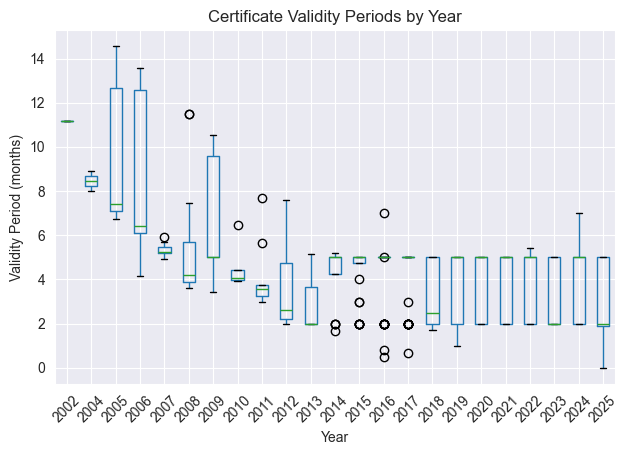

In [51]:
#Average validity period


# Add 'Year' and 'ValidityPeriod' in **months**
new_df['Year'] = new_df['IssueDate'].dt.year
new_df['ValidityPeriod'] = (new_df['SunsetDate'] - new_df['IssueDate']).dt.days / 365.25  # average days in a month

# Create the boxplot grouped by year
plt.figure(figsize=(12, 6))
new_df.boxplot(column='ValidityPeriod', by='Year')

# Titles and labels
plt.title('Certificate Validity Periods by Year')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Validity Period (months)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


